# Import Libraries

In [1]:
import re
import os
import tika
import nltk
import psutil
import locale
import gensim
import pyLDAvis
import numpy as np
from tqdm import tqdm
from tika import parser
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim.corpora as corpora
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

nltk.download(["punkt_tab", "wordnet", "stopwords"])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lydra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lydra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lydra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
os.path.dirname(os.getcwd())

'd:\\Projects\\Game of Thrones Chatbot'

In [3]:
os.path.join(os.getcwd(), "data")

'd:\\Projects\\Game of Thrones Chatbot\\src\\data'

# Reading Data

In [4]:
book_lists = [os.path.join(os.path.dirname(os.getcwd()), "data", book) for book in os.listdir(path="../data") if ".epub" in book]
book_lists

['d:\\Projects\\Game of Thrones Chatbot\\data\\A Clash of Kings.epub',
 'd:\\Projects\\Game of Thrones Chatbot\\data\\A Dance With Dragons.epub',
 'd:\\Projects\\Game of Thrones Chatbot\\data\\A Feast for Crows.epub',
 'd:\\Projects\\Game of Thrones Chatbot\\data\\A Game Of Thrones.epub',
 'd:\\Projects\\Game of Thrones Chatbot\\data\\A Storm of Swords.epub']

In [5]:
book_length = {}

for book in book_lists:
  filename_wo_ext = os.path.splitext(os.path.basename(book))[0]
  filename_wo_ext_cleaned = filename_wo_ext.replace(" ", "_")
  globals()[filename_wo_ext_cleaned] = parser.from_file(filename=book, )["content"]
  book_length[filename_wo_ext] = len(globals()[filename_wo_ext_cleaned].split())

2025-01-26 15:22:10,112 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


# EDA

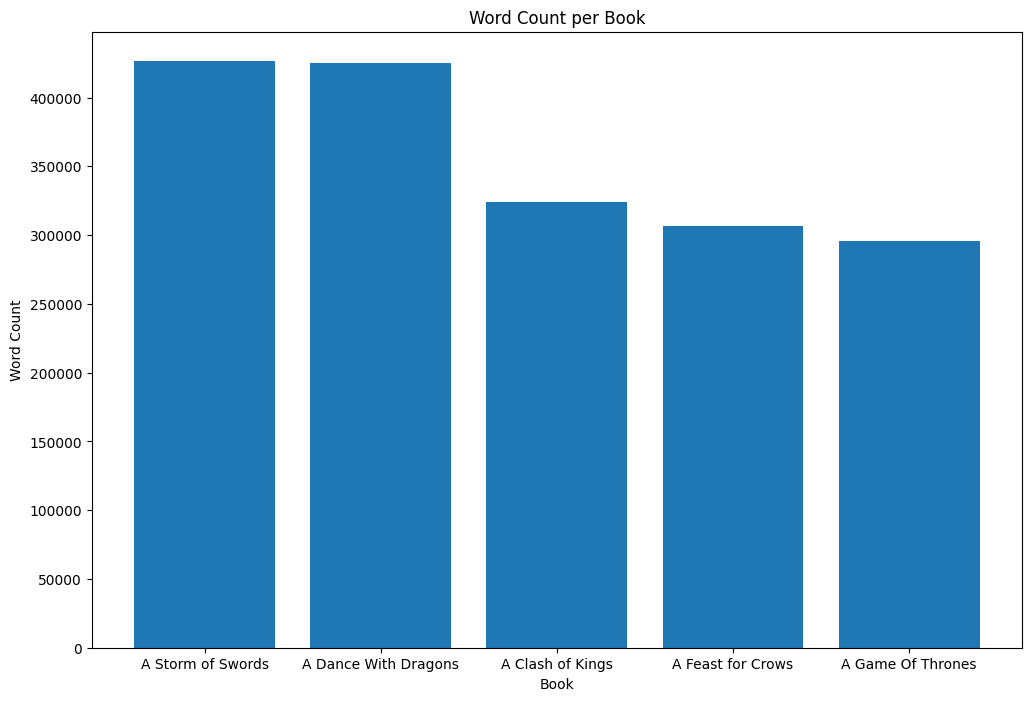

In [6]:
book_length = dict(sorted(book_length.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12,8))
plt.bar(x=book_length.keys(), height=book_length.values())
plt.xlabel("Book")
plt.ylabel("Word Count")
plt.title("Word Count per Book");

### As the books progress, each book contains more words

In [7]:
combined_books = A_Storm_of_Swords + A_Dance_With_Dragons + A_Clash_of_Kings + A_Feast_for_Crows + A_Game_Of_Thrones
combined_books =  re.sub(r"[^A-Za-z0-9\s]","", re.sub(r"www.\S+", "", combined_books))

with open("../data/combined_books.txt", "w") as f:
  f.write(combined_books)

combined_tokenized = word_tokenize(combined_books)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

combined_lemmatize = [lemmatizer.lemmatize(word) for word in tqdm(combined_tokenized) if word not in stop_words]

100%|██████████| 1773591/1773591 [00:08<00:00, 199892.44it/s]


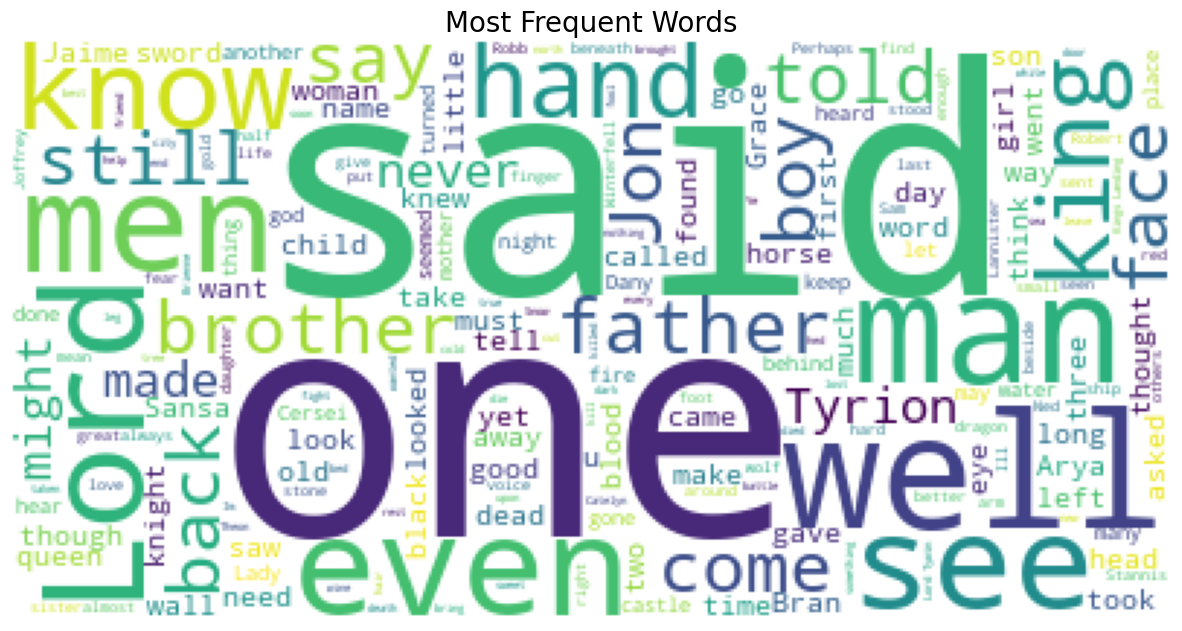

In [8]:
word_cloud = WordCloud(background_color="white").generate(" ".join(combined_lemmatize))
plt.figure(figsize=(15,8))
plt.axis("off")
plt.title("Most Frequent Words", fontsize=20)
plt.imshow(word_cloud);

The most frequent words are said, one, man and Lord among others

In [9]:
combined_books = " ".join(combined_lemmatize)
word_count = Counter(combined_lemmatize)
top_ten_words = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:10])

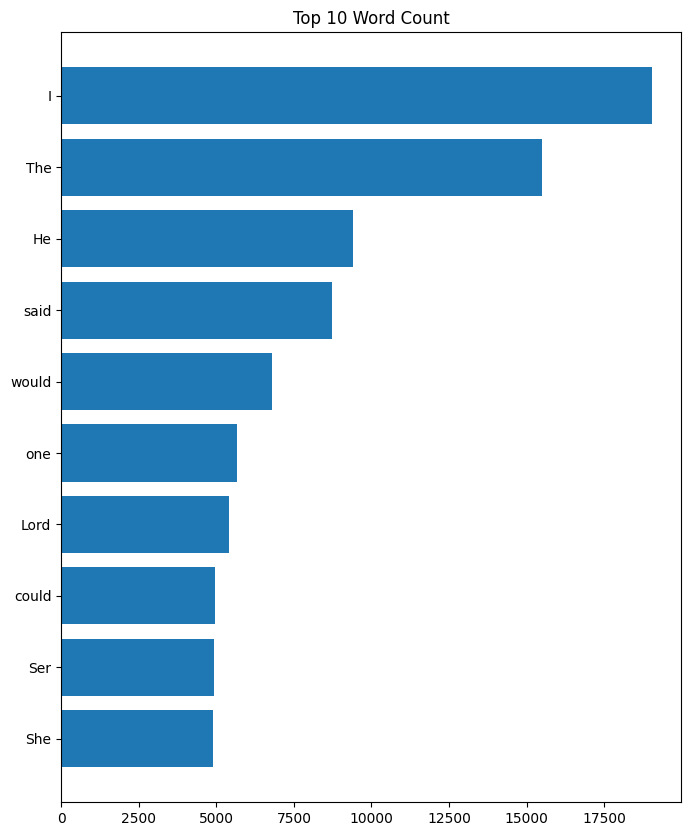

In [10]:
plt.figure(figsize=(8,10))
plt.barh(y=top_ten_words.keys(), width=top_ten_words.values())
plt.gca().invert_yaxis()
plt.title("Top 10 Word Count", fontsize=12);

Doing a bar plot on the most common words, I, The and He are the top 3 most common.

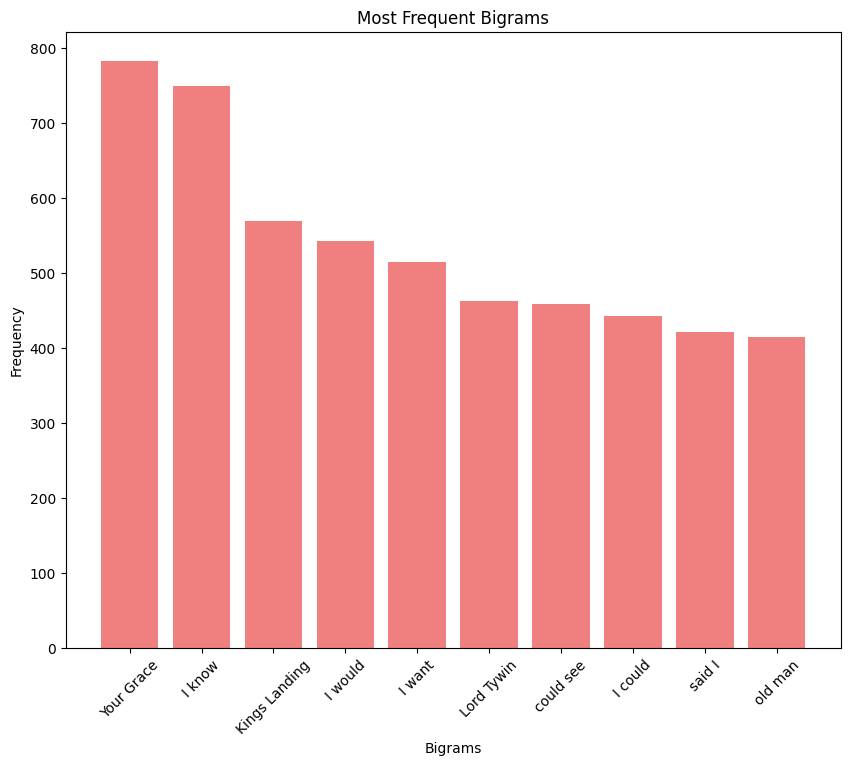

In [11]:
n = 2

bigrams = list(ngrams(combined_lemmatize, n=n))
top_bigrams = Counter(bigrams).most_common(10)
bigram_labels = [" ".join(bigram) for bigram,_ in top_bigrams]
bigram_freq = [freq for _, freq in top_bigrams]
plt.figure(figsize=(10,8))
plt.bar(bigram_labels, bigram_freq, color="lightcoral")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Most Frequent Bigrams")
plt.xticks(rotation=45)
plt.show();

Being a big fan of Game of Thrones, it is not suprising that the top 10 bigrams are listed in the plot above

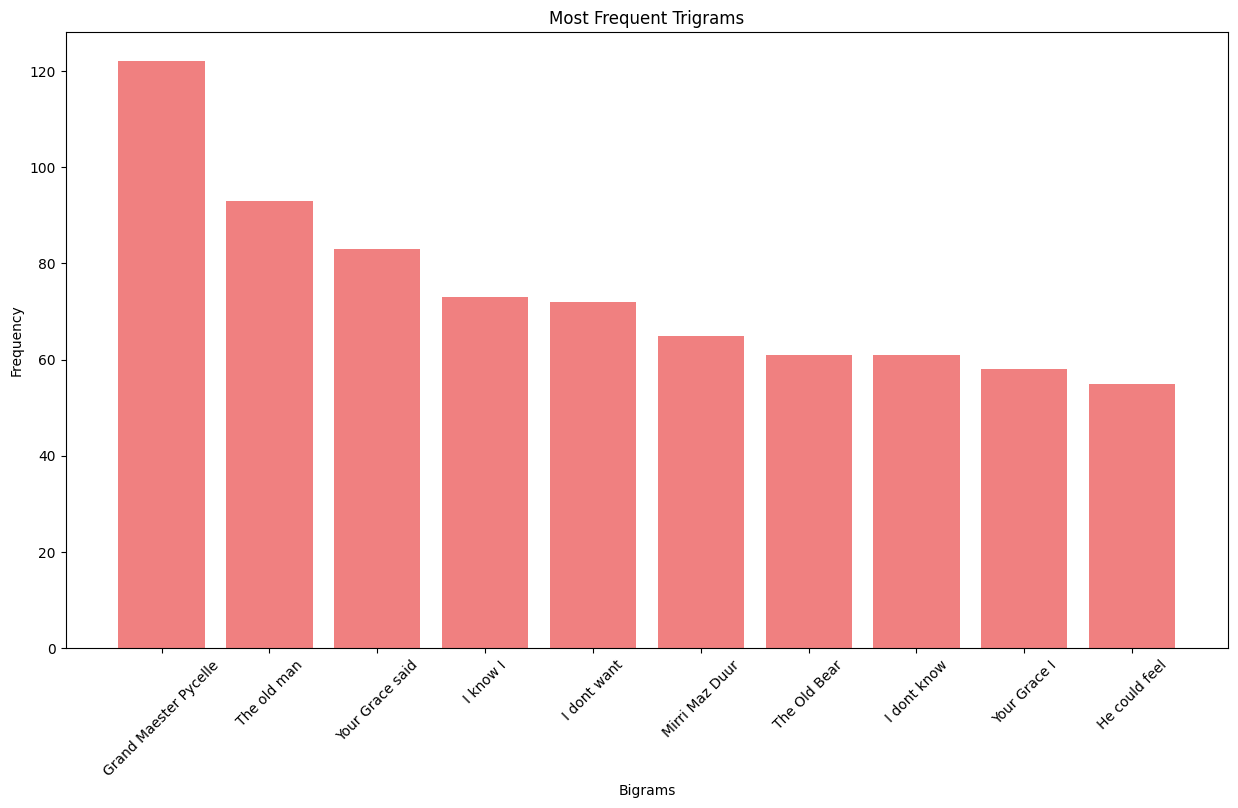

In [12]:
n = 3

trigrams = list(ngrams(combined_lemmatize, n=n))
top_trigrams = Counter(trigrams).most_common(10)
bigram_labels = [" ".join(trigram) for trigram,_ in top_trigrams]
trigram_freq = [freq for _, freq in top_trigrams]
plt.figure(figsize=(15,8))
plt.bar(bigram_labels, trigram_freq, color="lightcoral")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Most Frequent Trigrams")
plt.xticks(rotation=45)
plt.show();

The same sentiment can be echoed for trigram.

In [13]:
books = [A_Storm_of_Swords, A_Dance_With_Dragons, A_Clash_of_Kings, A_Feast_for_Crows, A_Game_Of_Thrones]
books = [re.sub(r"[^A-Za-z0-9\s]", "", re.sub(r"www.\S+", "", book)) for book in books]

In [14]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

combined_books_lemmatize = [
    [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(book) if word.lower() not in stop_words]
    for book in books]

In [15]:
id2word = corpora.Dictionary(combined_books_lemmatize)
dict(list(id2word.token2id.items())[:5])

{'0060827': 0, '10th': 1, '15th': 2, '16th': 3, '2000': 4}

In [16]:
corpus = [id2word.doc2bow(book) for book in combined_books_lemmatize]
for i in range(5):
  print(corpus[i][:5])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2)]
[(14, 4), (15, 20), (16, 38), (17, 8), (19, 6)]
[(15, 4), (16, 11), (17, 1), (18, 1), (19, 13)]
[(14, 8), (15, 5), (16, 9), (17, 3), (18, 2)]
[(14, 5), (15, 3), (16, 8), (18, 6), (19, 6)]


In [17]:
num_topics = 5
random_state = 42
passes = 20
iterations = 1_000

In [18]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations,
                                       workers=psutil.cpu_count(logical=False) - 1)

In [19]:
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(lda_vis)

Setting the number of topics to 5 shows no insight.

I will double the number of topics.

In [20]:
num_topics = 10
random_state = 42
passes = 20
iterations = 1_000

In [21]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations,
                                       workers=psutil.cpu_count(logical=False) - 1)
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(lda_vis)

Setting the number of topics to 10 shows insight.

There are 3 areas, 1 overlapping 2 and 3.

In [22]:
model = Word2Vec(sentences=combined_books_lemmatize, vector_size=10, min_count=1, workers=8)
words = list(model.wv.key_to_index)
word_vectors = model.wv[words]
tsne = TSNE(init="pca",
            n_components=3,
            random_state=42,
            angle=0.9,
            perplexity=10,
            max_iter=250,
            n_jobs=-1)
word_embeddings = tsne.fit_transform(word_vectors)

np.save("../data/embeddings/word_embeddings.npy", word_embeddings)
with open("../data/words.txt", "w") as f:
  for word in words:
    f.write(f"{word}\n")

100%|██████████| 22410/22410 [00:01<00:00, 16084.42it/s]


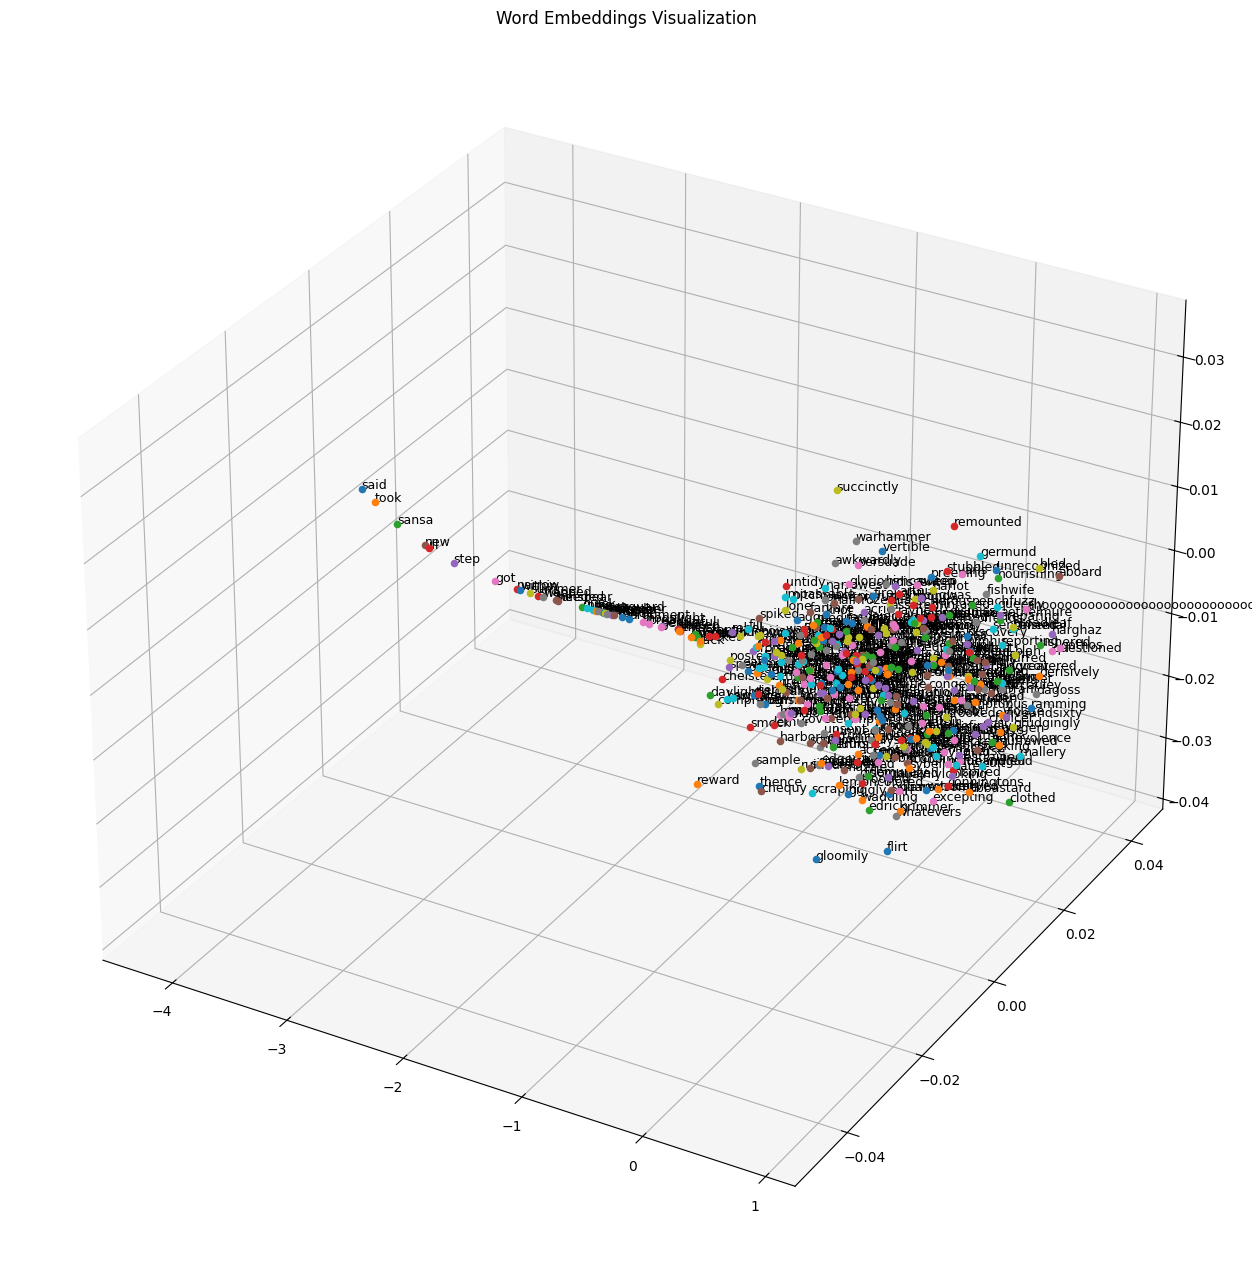

In [23]:
word_embeddings = np.load(file="../data/embeddings/word_embeddings.npy")
with open("../data/words.txt",
          "r",
          encoding=locale.getpreferredencoding()) as f:
          contents = f.readlines()
words = [line.strip() for line in contents]

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

for i, word in enumerate(tqdm(words)):
  if i % 50 == 0:
      ax.scatter(word_embeddings[i, 0],
                word_embeddings[i, 1],
                word_embeddings[i, 2])
      ax.text(word_embeddings[i, 0],
              word_embeddings[i, 1],
              word_embeddings[i, 2],
              word,
              fontsize=9)

ax.set_title("Word Embeddings Visualization")
plt.show()